> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

To-do: 

1. check out LSTM structure -> add dropout layer
2. Add detailed descriptions of each functions

# 05 - Different Anamaly Detection Algorithms

This tutorial is to identify anomalies using dataset from Numenta Anomaly Benchmark (NAB). This dataset contains ambient temperature in an office setting without any labelled anomalies. This is a good example to practice how to perform unsupervised learning to identify outliers.

In our tutorial, we will be using LSTM to detect anomalies based on the distance between data points.

Please note that there will be no accurate score as there is no label. We will visualize the anomalies to verify the performance of algorithm.

## Notebook Description
This tutorial will show different approaches other than deep learning that can be applied to search for anomalies. All the techniques is readily available in Scikit-learn library. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into anomaly detection algorithms
2. Apply different anomaly detection algorithms readily accessible from Scikit-learn API
3. Compare and contrast performance of anomaly detection algorithms

## Notebook Outline
Below is the outline for this tutorial:
1. [A Little Bit of Theory](#theory)
2. [Choice of Dataset](#dataset)
3. [Baseline Performance](#baseline)
4. [Anomaly Detection Techniques](#techniques) 
    * a) [Isolation Forest](#isolation-forest)
    * b) [Minimum Covariance Determinant](#minimum-cov-determinant)
    * c) [Local Outlier Factor (LOF)](#lof)
    * d) [One-class Support Vector Machine (OCSVM)](#ocsvm)

5. [Exercise](#exercise)
6. [Reference](#reference)

In [1]:
# libraries
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from fbprophet import Prophet

import time

## Data Loading

In [2]:
ROOT = Path.cwd().parent/'datasets'
EXTRACT_DIR = ROOT/'NAB_datasets'

# unzip file
import zipfile
path_to_zip_file = str(ROOT) + "/NAB-datasets.zip"
directory_to_extract_to = EXTRACT_DIR
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
df = pd.read_csv(str(EXTRACT_DIR) + "/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

## Exploratory Data Analysis (EDA)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [5]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [6]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


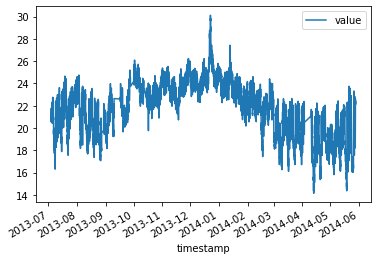

In [7]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value');

## Feature Engineering

In [8]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [9]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [10]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

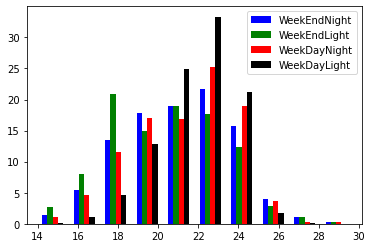

In [11]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

"We can see that the temperature is more stable during daylight of business day."

## Model Training

### 2.7 RNN

Use for sequential anomalies (ordered). RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [12]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].to_numpy()
y_train = data_n[prediction_time:-testdatacut  ][0].to_numpy()

# test data
x_test = data_n[0-testdatacut:-prediction_time].to_numpy()
y_test = data_n[prediction_time-testdatacut:  ][0].to_numpy()
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [13]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, IterableDataset
import torch
from torch import nn, optim
import torch.nn.functional as F

In [14]:
# Let us use the Dataset object to instantiate our dataset, this way it enables the use of len and indexing
# This is the preferred way of preparing data in Pytorch
class CreateDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [15]:
train_set = CreateDataset(x_train, y_train)
test_set = CreateDataset(x_test, y_test)

In [16]:
# this is just to configure model hyperparameters
# Input configurations
input_size = 5      # since one row has 5 features, we are reading one row at a time
sequence_length = 50 # since there are 50 rows 
num_layers = 2       # stack 2 LSTM together

# Hyperparameter
hidden_size = 128 # i think this is the number of hidden nodes
num_classes = 1
epochs = 35
batch_size = 200
learning_rate = 0.001

random_seed = 42

torch.manual_seed(random_seed) # to ensure reproducivility

In [17]:
# Now, we are ready to create iterator using DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=1,
                                          shuffle=False)

We can just load one batch of data to verify the functionality of our instantiated DataLoader.

In [60]:
next(iter(test_loader))

[tensor([[[-1.1074,  1.3701,  0.7068, -1.5095,  0.6213],
          [-1.0564,  1.5145,  0.7068, -1.5095,  0.6213],
          [-1.0756,  1.6589, -1.4148, -1.5095,  0.6213],
          [-1.4214, -1.6615, -1.4148, -1.0044,  0.6213],
          [-1.4141, -1.5172, -1.4148, -1.0044,  0.6213],
          [-1.8215, -1.3728, -1.4148, -1.0044,  0.6213],
          [-1.5958, -1.2284, -1.4148, -1.0044,  0.6213],
          [-1.8188, -1.0841, -1.4148, -1.0044,  0.6213],
          [-1.7948, -0.9397, -1.4148, -1.0044,  0.6213],
          [-1.9494, -0.7953, -1.4148, -1.0044,  0.6213],
          [-2.2294, -0.6510,  0.7068, -1.0044,  0.6213],
          [-1.7159, -0.5066,  0.7068, -1.0044,  0.6213],
          [-1.7076, -0.3623,  0.7068, -1.0044,  0.6213],
          [-1.2241, -0.2179,  0.7068, -1.0044,  0.6213],
          [-0.7299, -0.0735,  0.7068, -1.0044,  0.6213],
          [-0.6185,  0.0708,  0.7068, -1.0044,  0.6213],
          [-0.5741,  0.2152,  0.7068, -1.0044,  0.6213],
          [-0.2340,  0.3596,  0

In [19]:
# Let's instantiate a model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__() # this is for backward compatibility of Python 2, same as super().__init()
        self.hidden_size = hidden_size # this is to set attribute of the instance
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # in this order, so (28, 128, 2)
                                                                                 # batch_first set number of batch as 1st dimension
        # x -> (batch_size, seq, input_size) [the shape needed for the tensor]
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # initiate zeros tensor with (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # initiate zeros tensor with (num_layers, batch_size, hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        # output shape: batch_size, seq_length, hidden_size
        # out (N, 28, 128)
        out = out[:, -1, :]
        # out (N, 128)
        out = self.fc(out)
        return out
    
model = LSTM(input_size, hidden_size, num_layers, num_classes)
print(model)

# let's set loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# finally we can start to train
n_total_steps = len(train_loader)
print(n_total_steps)

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):          
        # forward pass
        outputs = model(x)
        y = y.view(-1, 1)
        loss = criterion(outputs, y)
        
        # backward pass
        optimizer.zero_grad() # this is to clear the parameters, done before each backward pass
        loss.backward()
        optimizer.step()
        
        # print out the training performance
        if (i+1) % 15 == 0:
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():10.4f}')

LSTM(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
31
Epoch [1/35], Step [15/31], Loss:     0.4377
Epoch [1/35], Step [30/31], Loss:     0.7837
Epoch [2/35], Step [15/31], Loss:     0.1921
Epoch [2/35], Step [30/31], Loss:     0.2006
Epoch [3/35], Step [15/31], Loss:     0.0752
Epoch [3/35], Step [30/31], Loss:     0.1474
Epoch [4/35], Step [15/31], Loss:     0.0594
Epoch [4/35], Step [30/31], Loss:     0.1490
Epoch [5/35], Step [15/31], Loss:     0.0566
Epoch [5/35], Step [30/31], Loss:     0.1712
Epoch [6/35], Step [15/31], Loss:     0.0549
Epoch [6/35], Step [30/31], Loss:     0.1505
Epoch [7/35], Step [15/31], Loss:     0.0508
Epoch [7/35], Step [30/31], Loss:     0.1271
Epoch [8/35], Step [15/31], Loss:     0.0462
Epoch [8/35], Step [30/31], Loss:     0.1200
Epoch [9/35], Step [15/31], Loss:     0.0428
Epoch [9/35], Step [30/31], Loss:     0.1161
Epoch [10/35], Step [15/31], Loss:     0.0400
Epoch [10/35], Step

In [53]:
import sys
# Let's evaluate our model
model.eval()
# Remember, we don't need to compute gradients as it is not required (and save some precious memory too!)
# create the list of difference between prediction and test data
p = np.empty_like(y_test.reshape(-1,1))

with torch.no_grad():
    for i, (x, y) in enumerate (test_loader):
        p[i] = model.forward(x).numpy()

ratio=[]
diff=[]
# print(p)
for u in range(len(y_test)):
    pr = p[u][0].item()
    ratio.append((y_test[u]/pr)-1)
    diff.append((abs(y_test[u]- pr)))


In [23]:
print(model)

LSTM(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


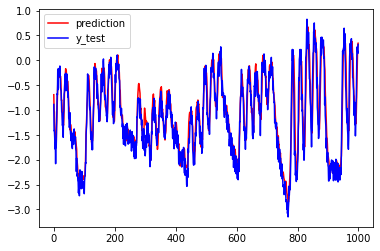

In [54]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [57]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


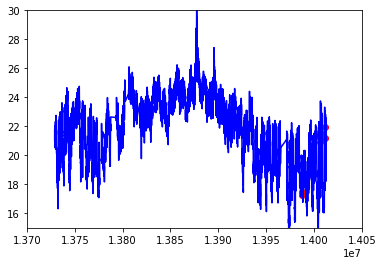

In [58]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

No handles with labels found to put in legend.


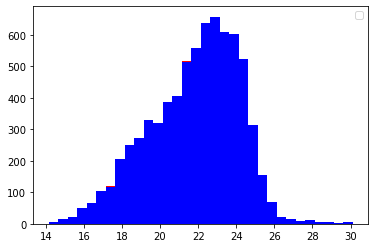

In [59]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

### 2.8 Collective and sequential anomalies (Ordered)

This class is most general and consider ordering as well as value combinations. We usually use combination of algorithm like cluster+markov model.

## <a name="reference">Reference</a>:
1. [Unsupervised Anomaly Detection](https://github.com/Vicam/Unsupervised_Anomaly_Detection)
3. [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab)